## Advanced Mini Project submission(MLEnd classification)

# Author
Student Name: Robert Lennart Manschke
Student ID: 210470194

# 2 Problem formulation

In this notebook we build an ML pipeline to differentiate between 8 segments of popular songs. We use the MLEnd Hums and Whistles dataset, containing hundreds of samples for all segments, in both hummed and whistled form. Classifying both representations(hum&whistle) through the same pipeline is challenging - they have large differences in pitch, noise/clarity and often accuracy. Audio data in general is also interesting because of the large amount of samples, usually in the kHz range. We need to drastically reduce the number of dimensions while still retaining the "essence" for the problem we are trying to solve. One exciting use-case for these methods is smusic recognition from inaccurate, human repetition. If we can differentiate well between 8 songs, then we could probably train the model to be able to recognize many other songs as well. 

In [3]:
import os,zipfile,glob,re
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [6]:
datapath="data/"
os.listdir(path)

['assignment_2_MLD_qmul.zip', 'ECS7027P Assignment 1 Dataset.zip']

In [11]:

# directory_to_extract_to = 'samples_advanced/'
# train_dataset_name='ECS7027P Assignment 1 Dataset.zip'
# with zipfile.ZipFile(datapath+train_dataset_name, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to+"train/")

# prod_dataset_name='assignment_2_MLD_qmul.zip'
# with zipfile.ZipFile(datapath+prod_dataset_name, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to+"prod/")


In [ ]:
#all label folders were manually moved, the containing folder deleted and the _MACOS_X folder deleted.

In [12]:
sample_path = 'samples_advanced/train/*/*.jpg'
files = glob.glob(sample_path)
num_files=len(files)

In [13]:
print(num_files)

43435


In [15]:
prod_path = 'samples_advanced/prod/*/*.jpg'
files_prod = glob.glob(prod_path)
num_files_prod=len(files_prod)

In [16]:
print(num_files_prod)

26124


Some students used spaces instead of underscores or brackets around the class, or e.g. 'harrypotter' instead of 'Potter', or switched up the order - we will have to overcome these by adapting the filenames and values

In [101]:
faces_table = [] 
files=[f.replace("\\","/") for f in files]
for file in files:
    file_name = "/".join(file.split('/')[-2:])
    try:
        file_data = file.split('/')[-2:]
        emotion_label = file_data[0]
        faces_table.append([file,file_name,emotion_label])
    except IndexError as e:
        print(e)
        print(file_name,file_data)


display(faces_table[:10])
faces_df = pd.DataFrame(faces_table,columns=['file_path','file_name','emotion_label']).set_index('file_name')
display(faces_df)
display(faces_df.nunique())
display(faces_df['emotion_label'].unique())

[['samples_advanced/train/ANGER/000046.jpg', 'ANGER/000046.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000047.jpg', 'ANGER/000047.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000050.jpg', 'ANGER/000050.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000051.jpg', 'ANGER/000051.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000053.jpg', 'ANGER/000053.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000062.jpg', 'ANGER/000062.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000063.jpg', 'ANGER/000063.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000064.jpg', 'ANGER/000064.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000065.jpg', 'ANGER/000065.jpg', 'ANGER'],
 ['samples_advanced/train/ANGER/000066.jpg', 'ANGER/000066.jpg', 'ANGER']]

,file_path,emotion_label
file_name,,
ANGER/000046.jpg,samples_advanced/train/ANGER/000046.jpg,ANGER
ANGER/000047.jpg,samples_advanced/train/ANGER/000047.jpg,ANGER
ANGER/000050.jpg,samples_advanced/train/ANGER/000050.jpg,ANGER
ANGER/000051.jpg,samples_advanced/train/ANGER/000051.jpg,ANGER
ANGER/000053.jpg,samples_advanced/train/ANGER/000053.jpg,ANGER
...,...,...
SURPRISE/013465.jpg,samples_advanced/train/SURPRISE/013465.jpg,SURPRISE
SURPRISE/013470.jpg,samples_advanced/train/SURPRISE/013470.jpg,SURPRISE
SURPRISE/013471.jpg,samples_advanced/train/SURPRISE/013471.jpg,SURPRISE


file_path        43435
emotion_label        6
dtype: int64

array(['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE'],
      dtype=object)

In [102]:
faces_table_prod = [] 
files_prod=[f.replace("\\","/") for f in files_prod]
for file in files_prod:
    file_name = "/".join(file.split('/')[-2:])
    try:
        file_data = file.split('/')[-2:]
        emotion_label = file_data[0]
        faces_table_prod.append([file,file_name,emotion_label])
    except IndexError as e:
        print(e)
        print(file_name,file_data)


display(faces_table_prod[:10])
faces_df_prod = pd.DataFrame(faces_table_prod,columns=['file_path','file_name','emotion_label']).set_index('file_name')
display(faces_df_prod)
display(faces_df_prod.nunique())
display(faces_df_prod['emotion_label'].unique())

[['samples_advanced/prod/ANGER/000002.jpg', 'ANGER/000002.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000004.jpg', 'ANGER/000004.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000006.jpg', 'ANGER/000006.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000008.jpg', 'ANGER/000008.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000010.jpg', 'ANGER/000010.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000012.jpg', 'ANGER/000012.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000014.jpg', 'ANGER/000014.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000016.jpg', 'ANGER/000016.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000018.jpg', 'ANGER/000018.jpg', 'ANGER'],
 ['samples_advanced/prod/ANGER/000020.jpg', 'ANGER/000020.jpg', 'ANGER']]

,file_path,emotion_label
file_name,,
ANGER/000002.jpg,samples_advanced/prod/ANGER/000002.jpg,ANGER
ANGER/000004.jpg,samples_advanced/prod/ANGER/000004.jpg,ANGER
ANGER/000006.jpg,samples_advanced/prod/ANGER/000006.jpg,ANGER
ANGER/000008.jpg,samples_advanced/prod/ANGER/000008.jpg,ANGER
ANGER/000010.jpg,samples_advanced/prod/ANGER/000010.jpg,ANGER
...,...,...
SURPRISE/014969.jpg,samples_advanced/prod/SURPRISE/014969.jpg,SURPRISE
SURPRISE/014970.jpg,samples_advanced/prod/SURPRISE/014970.jpg,SURPRISE
SURPRISE/014971.jpg,samples_advanced/prod/SURPRISE/014971.jpg,SURPRISE


file_path        26124
emotion_label        6
dtype: int64

array(['ANGER', 'DISGUST', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE'],
      dtype=object)

In [103]:
faces_df['emotion_label'].value_counts()

SADNESS      13040
HAPPINESS     9113
ANGER         8228
SURPRISE      7418
FEAR          2985
DISGUST       2651
Name: emotion_label, dtype: int64

In [104]:
faces_df_prod['emotion_label'].value_counts()

SADNESS      11939
SURPRISE      7244
ANGER         3427
DISGUST       1394
FEAR          1362
HAPPINESS      758
Name: emotion_label, dtype: int64

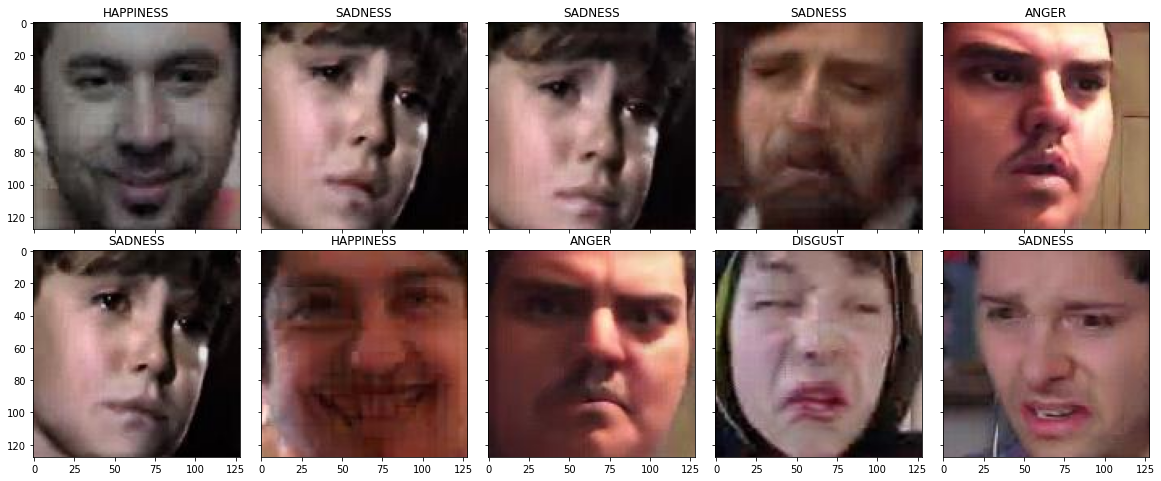

In [23]:
fig, axs = plt.subplots(2,5, figsize=(20,8),sharex=True, sharey=True)
for i in range(10):
    n = np.random.randint(num_files)
    img = mpimg.imread(files[n])
    axs[i//5, i%5].imshow(img)
    axs[i//5,i%5].title.set_text(faces_df.loc["/".join(files[n].split('/')[-2:])]["emotion_label"])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

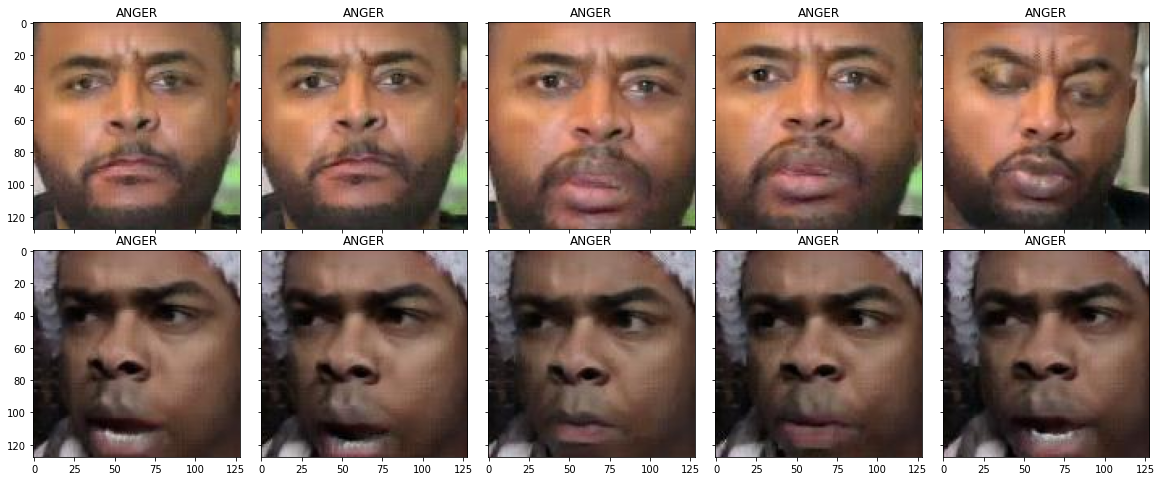

In [24]:
fig, axs = plt.subplots(2,5, figsize=(20,8),sharex=True, sharey=True)
for i in range(10):
    n = i
    img = mpimg.imread(files[n])
    axs[i//5, i%5].imshow(img)
    axs[i//5,i%5].title.set_text(faces_df.loc["/".join(files[n].split('/')[-2:])]["emotion_label"])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [25]:
def show_entry(n):
    return faces_df.loc["/".join(files[n].split('/')[-2:])]

In [26]:
def load_file(file):
    img = mpimg.imread(file)
    return img

file_path        samples_advanced/train/HAPPINESS/007900.jpg
emotion_label                                      HAPPINESS
Name: HAPPINESS/007900.jpg, dtype: object

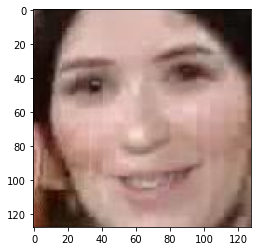

(128, 128, 3)


<BarContainer object of 256 artists>

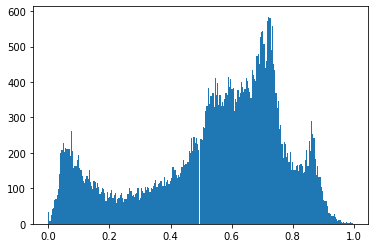

<BarContainer object of 256 artists>

<BarContainer object of 256 artists>

<BarContainer object of 256 artists>

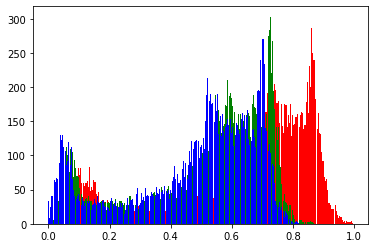

In [27]:
n=15515
img=load_file(files[n])
plt.imshow(img)
display(show_entry(n))
plt.show()
print(img.shape)
display(plt.hist((img/255).ravel(), bins=256)[2])
plt.show()
display(plt.hist((img[:,:,0]/255).ravel(), bins=256,color="red")[2])
display(plt.hist((img[:,:,1]/255).ravel(), bins=256,color="green")[2])
display(plt.hist((img[:,:,2]/255).ravel(), bins=256,color="blue")[2])

In [28]:
def getBrightness(img):
  brightness=img.mean()
  return brightness

In [29]:
getBrightness(img)

138.6801961263021

In [30]:
def scale_minmax(img):
    scaled=(img-img.ravel().min()+1)/(img.ravel().max()-img.ravel().min()+1)
    return scaled

In [31]:
print(getBrightness(scale_minmax(img)))

0.5477654750051061


In [32]:
def remove_shadows(img):
    img=img
    pixel_means=img.mean(axis=2)
    normalized=(img/pixel_means.repeat(3).reshape(img.shape))
    scaled=scale_minmax(normalized)
    scaled*=255
    scaled=scaled.astype(np.uint8)
    return scaled

file_path        samples_advanced/train/HAPPINESS/003324.jpg
emotion_label                                      HAPPINESS
Name: HAPPINESS/003324.jpg, dtype: object

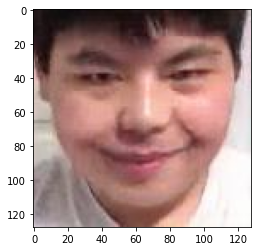

255 79


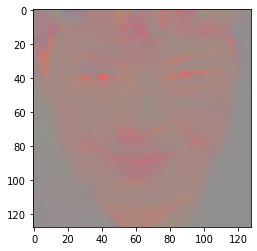

In [33]:
n=15000
img=load_file(files[n])
display(show_entry(n))
plt.imshow(img)
plt.show()
normalized=remove_shadows(img)
print(normalized.ravel().max(),normalized.ravel().min())
plt.imshow(normalized)
plt.show()

In [34]:
def histogramEq(_img):
    img_gray = cv2.cvtColor(_img, cv2.COLOR_RGB2GRAY)
    equalized=cv2.equalizeHist(img_gray)
    return equalized

file_path        samples_advanced/train/HAPPINESS/003324.jpg
emotion_label                                      HAPPINESS
Name: HAPPINESS/003324.jpg, dtype: object

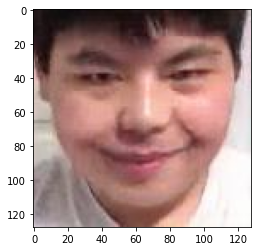

255 0


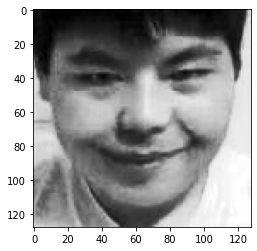

In [35]:
n=15000
img=load_file(files[n])
display(show_entry(n))
plt.imshow(img)
plt.show()
equalized=histogramEq(img)
print(equalized.ravel().max(),equalized.ravel().min())
plt.imshow(equalized,cmap='gray')
plt.show()

In [36]:
def getEdges(img):

    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img, (3,3), 0) 
    
    # Canny Edge Detection
    edges = cv2.Canny(image=img, threshold1=110, threshold2=220) # Canny Edge Detection
    return edges

In [37]:
faces_df.reset_index().index[faces_df["emotion_label"]=="FEAR"]

Int64Index([10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887,
            10888,
            ...
            13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862,
            13863],
           dtype='int64', length=2985)

file_path        samples_advanced/train/ANGER/000051.jpg
emotion_label                                      ANGER
Name: ANGER/000051.jpg, dtype: object

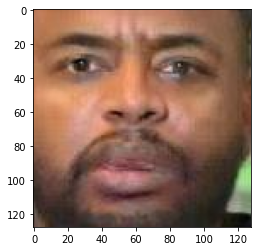

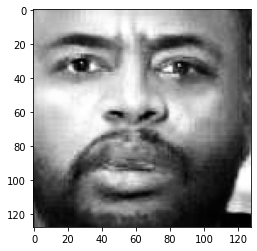

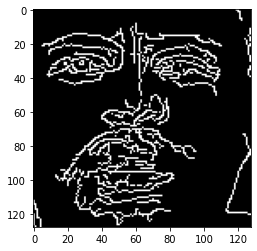

file_path        samples_advanced/train/DISGUST/004026.jpg
emotion_label                                      DISGUST
Name: DISGUST/004026.jpg, dtype: object

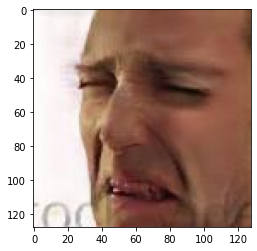

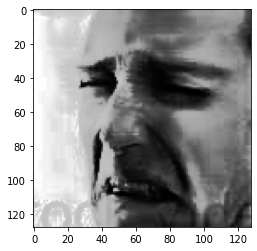

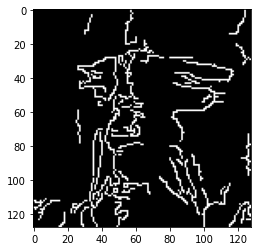

file_path        samples_advanced/train/FEAR/000184.jpg
emotion_label                                      FEAR
Name: FEAR/000184.jpg, dtype: object

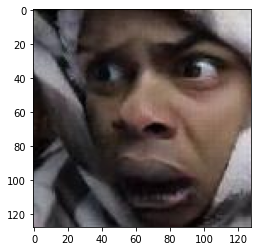

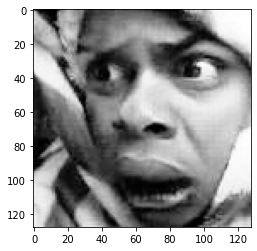

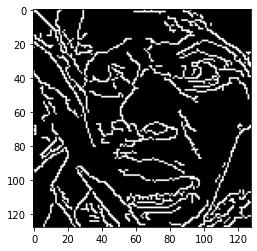

file_path        samples_advanced/train/HAPPINESS/039884.jpg
emotion_label                                      HAPPINESS
Name: HAPPINESS/039884.jpg, dtype: object

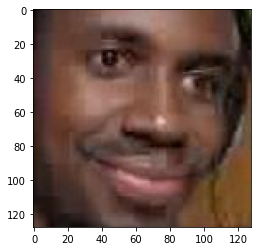

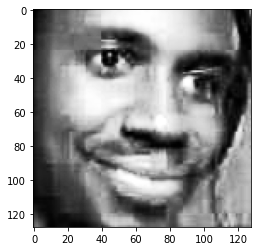

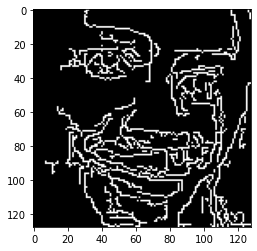

file_path        samples_advanced/train/SADNESS/016881.jpg
emotion_label                                      SADNESS
Name: SADNESS/016881.jpg, dtype: object

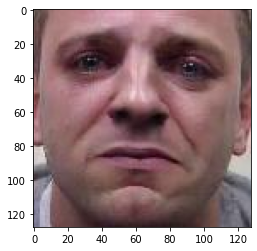

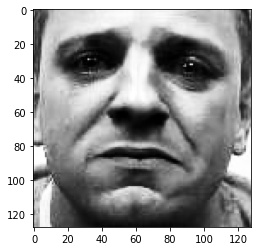

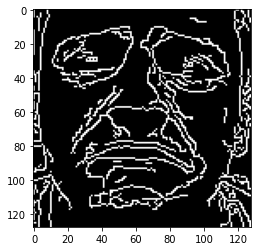

file_path        samples_advanced/train/SURPRISE/007435.jpg
emotion_label                                      SURPRISE
Name: SURPRISE/007435.jpg, dtype: object

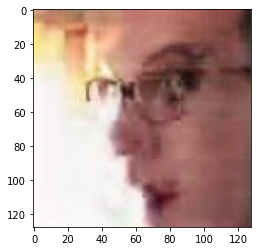

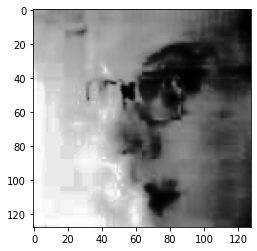

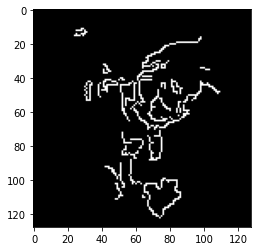

In [38]:
nums=[3,9000,11000,19000,25000,40001]
for n in nums:
    img=load_file(files[n])
    display(show_entry(n))
    plt.imshow(img)
    plt.show()
    normalized=histogramEq(img)
    plt.imshow(normalized,cmap="gray")
    plt.show()
    plt.imshow(getEdges(normalized),cmap="gray")
    plt.show()



In [39]:
img0=load_file(files[5000])
normalized0=histogramEq(img)
mysum=normalized.astype(np.float64)/20000
for file in tqdm(files[20000:40000]):
    img=load_file(file)
    normalized=histogramEq(img)
    mysum+=normalized/20000



100%|██████████| 20000/20000 [01:00<00:00, 331.74it/s]


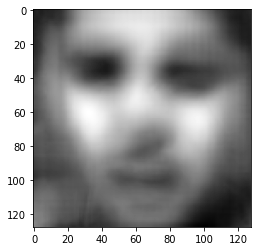

In [40]:
plt.imshow(mysum,cmap="gray")
plt.show()

In [442]:
def getXy(files,labels_file):
  myX,myY =[],[]
  for file in tqdm(files):
    fileID = "/".join(file.split('/')[-2:])
    yi = labels_file.loc[fileID]['emotion_label']

    img = load_file(file)
    scaled_img=np.moveaxis(scale_minmax(img),-1,0)
    normalized=scale_minmax(histogramEq(img))
    #edges=scale_minmax(getEdges(normalized))
    #xi = np.array([normalized,edges])
    xi=normalized
    myX.append(xi)
    myY.append(yi)

  return np.array(myX),np.array(myY)

In [443]:
try:
    del X
    del y
    del X_prod
    del y_prod
except NameError:
    pass

In [444]:

X,y=getXy(files[::40], labels_file=faces_df)

100%|██████████| 1086/1086 [00:01<00:00, 681.88it/s]


In [83]:
with open('X_and_y_preprocessed_1k.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [445]:
 X,y=getXy(files, labels_file=faces_df)

100%|██████████| 43435/43435 [01:38<00:00, 440.90it/s]


save to/load from file to save time when restarting the kernel

In [446]:
 X_prod,y_prod=getXy(files_prod, labels_file=faces_df_prod)

100%|██████████| 26124/26124 [00:42<00:00, 615.09it/s]


In [85]:
with open('X_and_y_preprocessed_all.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [107]:
with open('X_and_y_prod.npy', 'wb') as f:
    np.save(f, X)
    np.save(f, y)

In [117]:
with open('X_and_y_preprocessed_all.npy', 'rb') as f:
    X=np.load(f,allow_pickle=True)
    y=np.load(f,allow_pickle=True)

In [118]:
with open('X_and_y_prod.npy', 'rb') as f:
    X_prod=np.load(f,allow_pickle=True)
    y_prod=np.load(f,allow_pickle=True)

sanity check

In [447]:
#X= X.flatten().reshape(X.shape[0], np.prod(X.shape[1:]))
print(X.shape,y.shape)
print(X_prod.shape,y_prod.shape)

(43435, 128, 128) (43435,)
(26124, 128, 128) (26124,)


In [448]:
ydf=pd.DataFrame(y)
display(ydf.value_counts())
ydf=pd.DataFrame(y_prod)
display(ydf.value_counts())

SADNESS      13040
HAPPINESS     9113
ANGER         8228
SURPRISE      7418
FEAR          2985
DISGUST       2651
dtype: int64

SADNESS      11939
SURPRISE      7244
ANGER         3427
DISGUST       1394
FEAR          1362
HAPPINESS      758
dtype: int64

In [449]:
del ydf

In [450]:
print(X[1].shape,X_prod[1].shape)

(128, 128) (128, 128)


In [451]:
for i,seq in enumerate(X):
    if np.isnan(seq).all():
        print(i,seq)
for i,seq in enumerate(X_prod):
    if np.isnan(seq).all():
        print(i,seq)

In [452]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The shape of X_prod is', X_prod.shape) 
print('The shape of y_prod is', y_prod.shape)

The shape of X is (43435, 128, 128)
The shape of y is (43435,)
The shape of X_prod is (26124, 128, 128)
The shape of y_prod is (26124,)


In [453]:
import torch
import torch.nn as nn

In [468]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
ohencoder=OneHotEncoder(sparse=False)
y_onehot=ohencoder.fit_transform(y.reshape(-1,1))
y_prod_onehot=ohencoder.transform(y_prod.reshape(-1,1))
tensor_x = torch.Tensor(X).reshape((X.shape[0],1,*X.shape[1:])) # transform to torch tensor
tensor_x_prod= torch.Tensor(X_prod).reshape((X_prod.shape[0],1,*X_prod.shape[1:]))
tensor_y = torch.Tensor(y_onehot)
tensor_y_prod=torch.Tensor(y_prod_onehot)
print(tensor_x.shape,tensor_y.shape,tensor_x_prod.shape,tensor_y_prod.shape)
pytorch_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
prod_dataset=TensorDataset(tensor_x_prod,tensor_y_prod)
train_set,val_set,test_set=torch.utils.data.random_split(pytorch_dataset,(round(0.7*len(pytorch_dataset)),round(0.2*len(pytorch_dataset)),round(0.1*len(pytorch_dataset))))
train_loader = DataLoader(train_set, batch_size=256, shuffle=True) # create your dataloader
val_loader=DataLoader(val_set, batch_size=256, shuffle=False)
test_loader=DataLoader(test_set, batch_size=256, shuffle=False)
prod_loader=DataLoader(prod_dataset, batch_size=256, shuffle=False)
print(len(train_loader),len(val_loader),len(prod_loader))

torch.Size([43435, 1, 128, 128]) torch.Size([43435, 6]) torch.Size([26124, 1, 128, 128]) torch.Size([26124, 6])
119 34 103


In [469]:
def evaluation(net,dataloader):
  total, correct = 0,0
  # turn on evaluate mode, this de-activates dropout
  # (good practice to include in your projects even if it is not used)
  net.eval()
  for data in dataloader:
    
    inputs, labels = data
    inputs, labels = inputs.to(torch.device("cuda:0")), labels.to(torch.device("cuda:0"))
    outputs = torch.argmax(net(inputs), dim=1)
    labels=torch.argmax(labels,dim=1)
    # we take the index of the class that received the highest value  
    # we take outputs.data so that no backpropagation is performed for these outputs
    pred=outputs
    total += labels.size(0)
    # .item() takes Python float values from the tensor
    correct += (pred == labels).sum().item()
  
  return 100 * correct / total

In [470]:
def weights_init(m):
    # initialise both linear and convolutional layers
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d)or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [471]:
!nvidia-smi

Sun Jul 31 22:40:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8    12W /  N/A |   4668MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [472]:
from tqdm import tqdm
import time
def train_loop(dev,network,alpha,beta,max_epochs,output_pictures,opt,_train_loader,_val_loader):
    loss_fn = nn.CrossEntropyLoss()
    loss_fn.to(dev)
    # SGD optimiser, learning rate is specified by alpha
    #opt = torch.optim.SGD(list(network.parameters()), lr=alpha)

    #opt=torch.optim.SGD(netw|ork.parameters(),lr=alpha,momentum=beta[0])
    loss_epoch_array = []
    loss_epoch = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    for epoch in range(max_epochs):
        # we will compute sum of batch losses per epoch
        loss_epoch = 0
        # loop over batches
        loop=tqdm(_train_loader)
        total=0
        correct=0
        for i, data in enumerate(loop, 0):
            # to ensure the dropout is "turned on" while training
            # (good practice to include in your projects even if it is not used)
            network.train()
            inputs, labels = data
            inputs, labels = inputs, labels
            inputs,labels=inputs.to(dev), labels.to(dev)
            # zero the gradients
            opt.zero_grad()
            outputs = network(inputs)
            # compute the loss
            loss = loss_fn(outputs, labels.float())
            # calculate the gradients
            loss.backward()
            # update the parameters using the gradients and optimizer algorithm 
            opt.step()
            # we sum the loss over batches
            loss_epoch += loss.item()
            #=====
            pred = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            # .item() takes Python float values from the tensor
            correct += (pred == torch.argmax(labels,dim=1)).sum().item()
            #=======
        loss_epoch_array.append(loss_epoch)
        network.eval()
        train_accuracy.append(100 * correct / total)
        val_accuracy.append(evaluation(network,_val_loader))
        print("Epoch {}: loss: {}, train accuracy: {}, valid accuracy:{}".format(epoch + 1, loss_epoch_array[-1], train_accuracy[-1], val_accuracy[-1]))
        # if epoch>15 and np.mean(val_accuracy[-15:-10])>np.mean(val_accuracy[-5:]):
        #     break
    if output_pictures:   
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.plot(train_accuracy, "b")
        plt.plot(val_accuracy, "g")
        plt.gca().legend(('train','validation'))
        plt.show()

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(loss_epoch_array)
        plt.show()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(np.log(np.array(loss_epoch_array)))
        plt.show()
        print("====================================================")

In [481]:

class SimpleCNNClassifier(nn.Module):
    def __init__(self,act_fn,in_channels,dropout_amount=0):
        super(SimpleCNNClassifier,self).__init__()
        layer1_out=32
        self.nnmodel=nn.Sequential(  
                                        nn.Conv2d(in_channels,layer1_out,kernel_size=(3,3),stride=(2,2)),
                                        nn.BatchNorm2d(layer1_out),
                                        nn.Dropout(dropout_amount),
                                        act_fn(),
                                        nn.Conv2d(layer1_out,layer1_out*2,kernel_size=(3,3),stride=(2,2)),
                                        nn.BatchNorm2d(layer1_out*2),
                                        nn.Dropout(dropout_amount),
                                        act_fn(),
                                        nn.Conv2d(layer1_out*2,layer1_out*4,kernel_size=(3,3),stride=(2,2)),
                                        nn.BatchNorm2d(layer1_out*4),
                                        nn.Dropout(dropout_amount),
                                        act_fn(),
                                        nn.Conv2d(layer1_out*4,layer1_out*8,kernel_size=(3,3),stride=(2,2)),
                                        nn.BatchNorm2d(layer1_out*8),
                                        nn.Dropout(dropout_amount),
                                        act_fn(),
                                        nn.Conv2d(layer1_out*8,layer1_out*16,kernel_size=(3,3),stride=(2,2)),
                                        nn.BatchNorm2d(layer1_out*16),
                                        nn.Dropout(dropout_amount),
                                        act_fn(),
                                        nn.Flatten(),
                                        nn.Linear(layer1_out*16*3*3,6),
                                        act_fn(),
                                  )
    def forward(self, x):
        x = self.nnmodel(x)
        return x         

In [482]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [483]:
!pip install torchsummary
from torchsummary import summary


[notice] A new release of pip available: 22.2 -> 22.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [484]:
net=SimpleCNNClassifier(nn.LeakyReLU,in_channels=1,dropout_amount=0.3).to(device)
display(net)
summary(net,(1,128,128))

SimpleCNNClassifier(
  (nnmodel): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Conv2d(256, 512, kernel_si

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             320
       BatchNorm2d-2           [-1, 32, 63, 63]              64
           Dropout-3           [-1, 32, 63, 63]               0
         LeakyReLU-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
       BatchNorm2d-6           [-1, 64, 31, 31]             128
           Dropout-7           [-1, 64, 31, 31]               0
         LeakyReLU-8           [-1, 64, 31, 31]               0
            Conv2d-9          [-1, 128, 15, 15]          73,856
      BatchNorm2d-10          [-1, 128, 15, 15]             256
          Dropout-11          [-1, 128, 15, 15]               0
        LeakyReLU-12          [-1, 128, 15, 15]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
      BatchNorm2d-14            [-1, 25

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]             320
       BatchNorm2d-2           [-1, 32, 63, 63]              64
           Dropout-3           [-1, 32, 63, 63]               0
         LeakyReLU-4           [-1, 32, 63, 63]               0
            Conv2d-5           [-1, 64, 31, 31]          18,496
       BatchNorm2d-6           [-1, 64, 31, 31]             128
           Dropout-7           [-1, 64, 31, 31]               0
         LeakyReLU-8           [-1, 64, 31, 31]               0
            Conv2d-9          [-1, 128, 15, 15]          73,856
      BatchNorm2d-10          [-1, 128, 15, 15]             256
          Dropout-11          [-1, 128, 15, 15]               0
        LeakyReLU-12          [-1, 128, 15, 15]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
      BatchNorm2d-14            [-1, 25

100%|██████████| 119/119 [00:05<00:00, 23.32it/s]


Epoch 1: loss: 167.33231842517853, train accuracy: 48.6745165109854, valid accuracy:66.34050880626224


100%|██████████| 119/119 [00:04<00:00, 26.05it/s]


Epoch 2: loss: 69.10061731934547, train accuracy: 79.08827785817655, valid accuracy:80.99458961666859


100%|██████████| 119/119 [00:04<00:00, 25.98it/s]


Epoch 3: loss: 25.75402159243822, train accuracy: 93.74753321931325, valid accuracy:80.71831472314953


100%|██████████| 119/119 [00:04<00:00, 26.06it/s]


Epoch 4: loss: 13.906878175213933, train accuracy: 96.701091961584, valid accuracy:94.94647173938068


100%|██████████| 119/119 [00:04<00:00, 25.92it/s]


Epoch 5: loss: 7.8797840271145105, train accuracy: 98.112090514406, valid accuracy:96.31633475307932


100%|██████████| 119/119 [00:04<00:00, 25.95it/s]


Epoch 6: loss: 5.839022600790486, train accuracy: 98.53637679252729, valid accuracy:98.37688500057557


100%|██████████| 119/119 [00:04<00:00, 26.06it/s]


Epoch 7: loss: 4.576093026436865, train accuracy: 98.89488225233522, valid accuracy:98.30781627719581


100%|██████████| 119/119 [00:04<00:00, 25.96it/s]


Epoch 8: loss: 3.3088831678032875, train accuracy: 99.20734113932377, valid accuracy:98.77978588695753


100%|██████████| 119/119 [00:04<00:00, 25.92it/s]


Epoch 9: loss: 3.584981135034468, train accuracy: 99.18431785291409, valid accuracy:98.84885461033728


100%|██████████| 119/119 [00:04<00:00, 25.70it/s]


Epoch 10: loss: 2.7598036841955036, train accuracy: 99.31259044862519, valid accuracy:98.88338897202716


100%|██████████| 119/119 [00:04<00:00, 25.18it/s]


Epoch 11: loss: 2.7618120338011067, train accuracy: 99.3323246941192, valid accuracy:99.11361804995971


100%|██████████| 119/119 [00:04<00:00, 25.77it/s]


Epoch 12: loss: 2.0380118098983075, train accuracy: 99.45730824891461, valid accuracy:99.320824220099


100%|██████████| 119/119 [00:04<00:00, 25.72it/s]


Epoch 13: loss: 2.090095566760283, train accuracy: 99.50335482173398, valid accuracy:98.69920570968114


100%|██████████| 119/119 [00:04<00:00, 25.64it/s]


Epoch 14: loss: 1.8640520278859185, train accuracy: 99.53953427180635, valid accuracy:99.45896166685853


100%|██████████| 119/119 [00:04<00:00, 25.62it/s]


Epoch 15: loss: 1.6446484391926788, train accuracy: 99.51980002631232, valid accuracy:99.36687003568551


100%|██████████| 119/119 [00:04<00:00, 25.51it/s]


Epoch 16: loss: 1.1269547026313376, train accuracy: 99.66780686751743, valid accuracy:99.4474502129619


100%|██████████| 119/119 [00:04<00:00, 25.54it/s]


Epoch 17: loss: 1.115991415688768, train accuracy: 99.7237205630838, valid accuracy:99.41291585127202


100%|██████████| 119/119 [00:04<00:00, 25.46it/s]


Epoch 18: loss: 1.6395522897073533, train accuracy: 99.61189317195105, valid accuracy:99.17117531944285


100%|██████████| 119/119 [00:04<00:00, 25.53it/s]


Epoch 19: loss: 1.286353499875986, train accuracy: 99.69083015392711, valid accuracy:99.07908368826983


100%|██████████| 119/119 [00:04<00:00, 25.31it/s]


Epoch 20: loss: 1.6606988650310086, train accuracy: 99.54940139455334, valid accuracy:99.45896166685853


100%|██████████| 119/119 [00:04<00:00, 25.50it/s]


Epoch 21: loss: 1.5475747071614023, train accuracy: 99.59544796737272, valid accuracy:99.33233567399563


100%|██████████| 119/119 [00:04<00:00, 24.92it/s]


Epoch 22: loss: 1.2693618943740148, train accuracy: 99.64149454019208, valid accuracy:99.55105329803155


100%|██████████| 119/119 [00:04<00:00, 25.50it/s]


Epoch 23: loss: 1.6993950706382748, train accuracy: 99.59544796737272, valid accuracy:99.56256475192816


100%|██████████| 119/119 [00:04<00:00, 25.49it/s]


Epoch 24: loss: 1.5191899769270094, train accuracy: 99.65793974477043, valid accuracy:99.24024404282261


100%|██████████| 119/119 [00:04<00:00, 25.56it/s]


Epoch 25: loss: 1.4393069726938847, train accuracy: 99.63820549927641, valid accuracy:98.2617704616093


100%|██████████| 119/119 [00:04<00:00, 25.64it/s]


Epoch 26: loss: 1.0720636635451228, train accuracy: 99.70069727667412, valid accuracy:99.55105329803155


100%|██████████| 119/119 [00:04<00:00, 25.64it/s]


Epoch 27: loss: 1.2906822887525777, train accuracy: 99.65793974477043, valid accuracy:99.41291585127202


100%|██████████| 119/119 [00:04<00:00, 25.70it/s]


Epoch 28: loss: 1.0177668733231258, train accuracy: 99.73358768583081, valid accuracy:99.38989294347876


100%|██████████| 119/119 [00:04<00:00, 25.69it/s]


Epoch 29: loss: 0.7777030111683416, train accuracy: 99.78292329956585, valid accuracy:98.0085184758835


100%|██████████| 119/119 [00:04<00:00, 25.69it/s]


Epoch 30: loss: 1.2037633303916664, train accuracy: 99.69411919484278, valid accuracy:98.95245769540693


100%|██████████| 119/119 [00:04<00:00, 25.69it/s]


Epoch 31: loss: 1.2564327340332966, train accuracy: 99.64478358110775, valid accuracy:99.52803039023829


100%|██████████| 119/119 [00:04<00:00, 24.88it/s]


Epoch 32: loss: 1.2069026676817884, train accuracy: 99.69411919484278, valid accuracy:89.74329457810522


100%|██████████| 119/119 [00:04<00:00, 24.99it/s]


Epoch 33: loss: 1.2513654064678121, train accuracy: 99.67767399026444, valid accuracy:99.59709911361804


100%|██████████| 119/119 [00:04<00:00, 25.19it/s]


Epoch 34: loss: 0.8618204229733237, train accuracy: 99.78950138139719, valid accuracy:99.37838148958214


100%|██████████| 119/119 [00:04<00:00, 25.67it/s]


Epoch 35: loss: 1.3068302689644042, train accuracy: 99.63491645836075, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.70it/s]


Epoch 36: loss: 1.0028484224458225, train accuracy: 99.74345480857782, valid accuracy:99.43593875906527


100%|██████████| 119/119 [00:04<00:00, 25.68it/s]


Epoch 37: loss: 1.02656766360451, train accuracy: 99.74674384949348, valid accuracy:99.45896166685853


100%|██████████| 119/119 [00:04<00:00, 25.69it/s]


Epoch 38: loss: 0.7368985747907573, train accuracy: 99.80594658597553, valid accuracy:99.48198457465178


100%|██████████| 119/119 [00:04<00:00, 25.65it/s]


Epoch 39: loss: 0.9792843104623898, train accuracy: 99.7566109722405, valid accuracy:99.43593875906527


100%|██████████| 119/119 [00:04<00:00, 25.69it/s]


Epoch 40: loss: 1.2964707149358219, train accuracy: 99.69411919484278, valid accuracy:99.0675722343732


100%|██████████| 119/119 [00:04<00:00, 25.67it/s]


Epoch 41: loss: 0.7050223505575559, train accuracy: 99.80594658597553, valid accuracy:99.45896166685853


100%|██████████| 119/119 [00:04<00:00, 25.63it/s]


Epoch 42: loss: 1.078518004160287, train accuracy: 99.73358768583081, valid accuracy:99.33233567399563


100%|██████████| 119/119 [00:04<00:00, 25.09it/s]


Epoch 43: loss: 0.7130051965978055, train accuracy: 99.80265754505986, valid accuracy:99.52803039023829


100%|██████████| 119/119 [00:04<00:00, 25.63it/s]


Epoch 44: loss: 0.6086878036330745, train accuracy: 99.82568083146954, valid accuracy:99.14815241164959


100%|██████████| 119/119 [00:04<00:00, 25.63it/s]


Epoch 45: loss: 0.9129655895267206, train accuracy: 99.7566109722405, valid accuracy:98.87187751813055


100%|██████████| 119/119 [00:04<00:00, 25.65it/s]


Epoch 46: loss: 0.9673774001275888, train accuracy: 99.72043152216814, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.64it/s]


Epoch 47: loss: 1.2005199847117183, train accuracy: 99.71056439942113, valid accuracy:99.15966386554622


100%|██████████| 119/119 [00:04<00:00, 24.86it/s]


Epoch 48: loss: 1.258776506085269, train accuracy: 99.6710959084331, valid accuracy:99.320824220099


100%|██████████| 119/119 [00:04<00:00, 25.12it/s]


Epoch 49: loss: 0.9655219441383451, train accuracy: 99.75990001315617, valid accuracy:99.4934960285484


100%|██████████| 119/119 [00:04<00:00, 25.17it/s]


Epoch 50: loss: 1.2459461789549096, train accuracy: 99.69411919484278, valid accuracy:99.51651893634165


100%|██████████| 119/119 [00:04<00:00, 25.35it/s]


Epoch 51: loss: 1.0300086837714844, train accuracy: 99.76318905407183, valid accuracy:99.41291585127202


100%|██████████| 119/119 [00:04<00:00, 25.04it/s]


Epoch 52: loss: 1.0746466203054297, train accuracy: 99.75003289040916, valid accuracy:99.38989294347876


100%|██████████| 119/119 [00:04<00:00, 24.81it/s]


Epoch 53: loss: 1.0119865208043848, train accuracy: 99.7763452177345, valid accuracy:99.41291585127202


100%|██████████| 119/119 [00:04<00:00, 25.49it/s]


Epoch 54: loss: 0.7000879448432897, train accuracy: 99.80594658597553, valid accuracy:99.47047312075514


100%|██████████| 119/119 [00:04<00:00, 25.50it/s]


Epoch 55: loss: 0.7426877844900446, train accuracy: 99.81252466780687, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.46it/s]


Epoch 56: loss: 0.9008082337895758, train accuracy: 99.77963425865018, valid accuracy:99.59709911361804


100%|██████████| 119/119 [00:04<00:00, 25.52it/s]


Epoch 57: loss: 0.6872755267941102, train accuracy: 99.85528219971056, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.48it/s]


Epoch 58: loss: 0.6683460984959311, train accuracy: 99.85857124062623, valid accuracy:99.38989294347876


100%|██████████| 119/119 [00:04<00:00, 25.51it/s]


Epoch 59: loss: 0.8510933788602415, train accuracy: 99.78292329956585, valid accuracy:99.47047312075514


100%|██████████| 119/119 [00:04<00:00, 25.45it/s]


Epoch 60: loss: 0.7717901881742364, train accuracy: 99.79279042231285, valid accuracy:99.53954184413492


100%|██████████| 119/119 [00:04<00:00, 25.47it/s]


Epoch 61: loss: 0.9026797169317433, train accuracy: 99.80265754505986, valid accuracy:99.58558765972143


100%|██████████| 119/119 [00:04<00:00, 25.50it/s]


Epoch 62: loss: 0.7614537257522898, train accuracy: 99.79279042231285, valid accuracy:99.68919074479106


100%|██████████| 119/119 [00:04<00:00, 25.52it/s]


Epoch 63: loss: 0.9747850893884333, train accuracy: 99.79607946322852, valid accuracy:99.4934960285484


100%|██████████| 119/119 [00:04<00:00, 24.74it/s]


Epoch 64: loss: 1.185504072848289, train accuracy: 99.73687672674649, valid accuracy:99.50500748244504


100%|██████████| 119/119 [00:04<00:00, 25.46it/s]


Epoch 65: loss: 0.8112028746254509, train accuracy: 99.81581370872253, valid accuracy:99.64314492920455


100%|██████████| 119/119 [00:04<00:00, 25.49it/s]


Epoch 66: loss: 0.8553834716053643, train accuracy: 99.80594658597553, valid accuracy:99.58558765972143


100%|██████████| 119/119 [00:04<00:00, 25.54it/s]


Epoch 67: loss: 0.7523910157642604, train accuracy: 99.8092356268912, valid accuracy:99.73523656037757


100%|██████████| 119/119 [00:04<00:00, 25.50it/s]


Epoch 68: loss: 0.9357918091002375, train accuracy: 99.77963425865018, valid accuracy:99.43593875906527


100%|██████████| 119/119 [00:04<00:00, 25.47it/s]


Epoch 69: loss: 0.7052581189536795, train accuracy: 99.84212603604789, valid accuracy:99.60861056751467


100%|██████████| 119/119 [00:04<00:00, 25.51it/s]


Epoch 70: loss: 0.6730993410494648, train accuracy: 99.83225891330088, valid accuracy:99.66616783699781


100%|██████████| 119/119 [00:04<00:00, 25.51it/s]


Epoch 71: loss: 0.38376376275346047, train accuracy: 99.9046178134456, valid accuracy:99.43593875906527


100%|██████████| 119/119 [00:04<00:00, 25.48it/s]


Epoch 72: loss: 0.7758472592031467, train accuracy: 99.83554795421655, valid accuracy:99.50500748244504


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 73: loss: 0.6059973868643738, train accuracy: 99.84212603604789, valid accuracy:99.36687003568551


100%|██████████| 119/119 [00:04<00:00, 24.93it/s]


Epoch 74: loss: 1.0828142452674, train accuracy: 99.75990001315617, valid accuracy:99.50500748244504


100%|██████████| 119/119 [00:04<00:00, 25.51it/s]


Epoch 75: loss: 1.0135088403387726, train accuracy: 99.77305617681884, valid accuracy:98.49199953954185


100%|██████████| 119/119 [00:04<00:00, 25.49it/s]


Epoch 76: loss: 0.9943621058793042, train accuracy: 99.78292329956585, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.45it/s]


Epoch 77: loss: 1.249503407548218, train accuracy: 99.75990001315617, valid accuracy:99.6201220214113


100%|██████████| 119/119 [00:04<00:00, 25.09it/s]


Epoch 78: loss: 0.7597661479767339, train accuracy: 99.84212603604789, valid accuracy:99.71221365258432


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 79: loss: 0.8505692916814951, train accuracy: 99.78950138139719, valid accuracy:99.1941982272361


100%|██████████| 119/119 [00:04<00:00, 25.43it/s]


Epoch 80: loss: 0.2767306924477708, train accuracy: 99.93093014077095, valid accuracy:99.7007021986877


100%|██████████| 119/119 [00:04<00:00, 25.44it/s]


Epoch 81: loss: 0.32075531406303526, train accuracy: 99.90790685436127, valid accuracy:99.59709911361804


100%|██████████| 119/119 [00:04<00:00, 25.45it/s]


Epoch 82: loss: 0.3294874080893919, train accuracy: 99.91777397710827, valid accuracy:99.64314492920455


100%|██████████| 119/119 [00:04<00:00, 25.43it/s]


Epoch 83: loss: 0.6470057492574028, train accuracy: 99.89803973161426, valid accuracy:99.56256475192816


100%|██████████| 119/119 [00:04<00:00, 25.45it/s]


Epoch 84: loss: 0.6594467089308864, train accuracy: 99.84870411787922, valid accuracy:99.34384712789225


100%|██████████| 119/119 [00:04<00:00, 24.78it/s]


Epoch 85: loss: 0.7877048036884844, train accuracy: 99.82568083146954, valid accuracy:99.27477840451249


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 86: loss: 0.6613748678619231, train accuracy: 99.86186028154191, valid accuracy:99.60861056751467


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 87: loss: 0.6632921819699504, train accuracy: 99.8519931587949, valid accuracy:99.40140439737539


100%|██████████| 119/119 [00:04<00:00, 25.39it/s]


Epoch 88: loss: 0.7233821050675147, train accuracy: 99.83225891330088, valid accuracy:99.53954184413492


100%|██████████| 119/119 [00:04<00:00, 25.46it/s]


Epoch 89: loss: 0.8601410869902679, train accuracy: 99.79607946322852, valid accuracy:99.50500748244504


100%|██████████| 119/119 [00:04<00:00, 25.43it/s]


Epoch 90: loss: 0.6013921077098985, train accuracy: 99.84541507696356, valid accuracy:99.65465638310118


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 91: loss: 0.7598087677026228, train accuracy: 99.83225891330088, valid accuracy:99.60861056751467


100%|██████████| 119/119 [00:04<00:00, 25.39it/s]


Epoch 92: loss: 0.6427784356151136, train accuracy: 99.89475069069859, valid accuracy:99.65465638310118


100%|██████████| 119/119 [00:04<00:00, 25.43it/s]


Epoch 93: loss: 0.9664095351945434, train accuracy: 99.83225891330088, valid accuracy:99.56256475192816


100%|██████████| 119/119 [00:04<00:00, 25.42it/s]


Epoch 94: loss: 0.9586495455517934, train accuracy: 99.82239179055388, valid accuracy:99.55105329803155


100%|██████████| 119/119 [00:04<00:00, 24.86it/s]


Epoch 95: loss: 0.49815136803039195, train accuracy: 99.86843836337324, valid accuracy:99.59709911361804


100%|██████████| 119/119 [00:04<00:00, 25.41it/s]


Epoch 96: loss: 0.7609863634586134, train accuracy: 99.82896987238522, valid accuracy:99.52803039023829


100%|██████████| 119/119 [00:04<00:00, 25.35it/s]


Epoch 97: loss: 0.8011942737322215, train accuracy: 99.8519931587949, valid accuracy:99.48198457465178


100%|██████████| 119/119 [00:04<00:00, 25.42it/s]


Epoch 98: loss: 0.49489619712500144, train accuracy: 99.88159452703592, valid accuracy:99.5740762058248


100%|██████████| 119/119 [00:04<00:00, 25.40it/s]


Epoch 99: loss: 0.5511377489477312, train accuracy: 99.87501644520458, valid accuracy:99.52803039023829


100%|██████████| 119/119 [00:04<00:00, 25.42it/s]


Epoch 100: loss: 0.5947306088382618, train accuracy: 99.85857124062623, valid accuracy:99.63163347530794


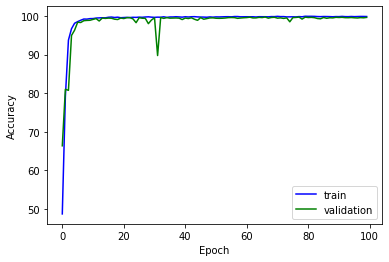

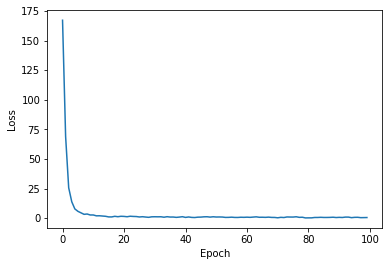

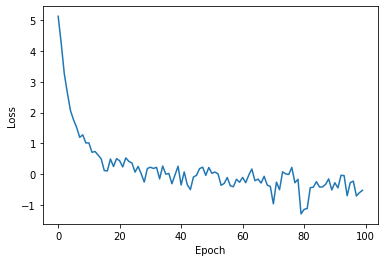

In [485]:
alpha = .005
beta= (0.7,0.999)
net=SimpleCNNClassifier(nn.LeakyReLU,in_channels=1,dropout_amount=0.3).to(device)
net.apply(weights_init)
summary(net,(1,128,128))
opt=torch.optim.Adam(net.parameters(), lr=alpha,betas=beta)
train_loop(device,net,alpha,beta,100,True,opt,train_loader,val_loader)


In [486]:
evaluation(net,test_loader)

99.65469613259668

In [487]:
evaluation(net,prod_loader)

87.97274536824376